Actor Network

In [1]:
import torch
import torch.nn as nn
from torch.distributions import Normal


class Actor(nn.Module):
    """
    Stochastic Actor Network for SAC (Gaussian Policy with Tanh Squash)
    Supports per-dimension action ranges, e.g.
    min_action = [-1, -2, -0.5]
    max_action = [ 1,  2,  1.0]
    """
    def __init__(self, state_dim, action_dim, min_action, max_action):
        super().__init__()

        # Ensure min/max are tensors with correct shape
        min_action = torch.tensor(min_action, dtype=torch.float32)
        max_action = torch.tensor(max_action, dtype=torch.float32)

        assert min_action.shape == (action_dim,)
        assert max_action.shape == (action_dim,)

        # Register as buffers (moved automatically with model.to(device))
        self.register_buffer("min_action", min_action)
        self.register_buffer("max_action", max_action)

        # Actor network
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, action_dim),
        )

        # Learnable log standard deviation
        self.log_std = nn.Parameter(torch.zeros(action_dim))

        # Limit std range for stability
        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX = 2

    def forward(self, state):
        """
        Returns mean and std of the Gaussian policy BEFORE tanh squash.
        """
        mean = self.net(state)

        # Clamp log_std for stability
        log_std = torch.clamp(self.log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        std = torch.exp(log_std)

        return mean, std

    def sample(self, state):
        """
        Returns:
        - scaled action (after tanh + min/max scaling)
        - log_prob of the action (required for SAC)
        """
        mean, std = self.forward(state)
        dist = Normal(mean, std)

        # Reparameterization trick
        x_t = dist.rsample()
        y_t = torch.tanh(x_t)

        # Scale [-1,1] → [min,max]
        action = self.min_action + (y_t + 1) * 0.5 * (self.max_action - self.min_action)

        # Log probability with tanh correction
        log_prob = dist.log_prob(x_t)
        log_prob -= torch.log(1 - y_t.pow(2) + 1e-6)
        log_prob = torch.sum(log_prob, dim=1, keepdim=True)

        return action, log_prob

    def sample_deterministic(self, state):
        """
        Returns deterministic action (mean → tanh → scaled)
        """
        mean, _ = self.forward(state)
        y_t = torch.tanh(mean)

        action = self.min_action + (y_t + 1) * 0.5 * (self.max_action - self.min_action)
        return action


In [2]:
state_dim = 5
action_dim = 3
min_action = [0, 0, 0.5]
max_action = [1, 2, 1]

# สร้าง Actor
actor = Actor(state_dim, action_dim, min_action, max_action)

# ส่งไป GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actor.to(device)

# สร้าง dummy state เพื่อทดสอบ
state = torch.randn(1, state_dim).to(device)  # batch size 1
action, log_prob = actor.sample(state)

print("Sampled action:\n", action)
print("Log probability:\n", log_prob)

Sampled action:
 tensor([[0.7559, 0.2541, 0.6925]], device='cuda:0', grad_fn=<AddBackward0>)
Log probability:
 tensor([[-2.0817]], device='cuda:0', grad_fn=<SumBackward1>)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------

Critic Network

In [3]:
import torch
import torch.nn as nn


class Critic(nn.Module):
    """
    Twin Q Network for SAC (Q1 and Q2)
    Inputs:
        state:  [batch, state_dim]
        action: [batch, action_dim]
    Output:
        q1, q2: [batch, 1]
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()

        # Q1 network
        self.q1_net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

        # Q2 network
        self.q2_net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

        # Apply weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """
        Custom weight initialization for better stability.
        """
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, state, action):
        """
        Forward both Q networks.
        """
        # Ensure concatenation on correct dimension
        sa = torch.cat([state, action], dim=1)

        q1 = self.q1_net(sa)
        q2 = self.q2_net(sa)
        return q1, q2


In [4]:
state_dim = 5
action_dim = 3

critic = Critic(state_dim, action_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
critic.to(device)

# Dummy state & action
state = torch.randn(1, state_dim).to(device)  # batch size 1
action = torch.randn(1, action_dim).to(device)

q1, q2 = critic(state, action)
print("Q1:\n", q1)
print("Q2:\n", q2)


Q1:
 tensor([[0.0240]], device='cuda:0', grad_fn=<AddmmBackward0>)
Q2:
 tensor([[0.0733]], device='cuda:0', grad_fn=<AddmmBackward0>)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------

Replaybuffer memory

In [5]:
import numpy as np
import torch

class Vanilla_ReplayBuffer:
    """
    Standard Replay Buffer for off-policy RL (SAC, TD3, DDPG)
    Features:
    - Fast NumPy storage
    - Tensor conversion only during sampling
    - Supports large batches efficiently
    - Works with GPU via device argument
    """
    def __init__(self, state_dim, action_dim, capacity=100000, device='cpu'):
        self.capacity = capacity
        self.device = device

        self.ptr = 0      # write pointer
        self.size = 0     # current size

        # Pre-allocate memory (fast!)
        self.state = np.zeros((capacity, state_dim), dtype=np.float32)
        self.action = np.zeros((capacity, action_dim), dtype=np.float32)
        self.reward = np.zeros((capacity, 1), dtype=np.float32)
        self.next_state = np.zeros((capacity, state_dim), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=np.float32)

    def push(self, s, a, r, s2, d):
        """
        Store one transition (s, a, r, s2, done)
        """
        i = self.ptr

        self.state[i] = s
        self.action[i] = a
        self.reward[i] = r
        self.next_state[i] = s2
        self.done[i] = d

        # Move pointer
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        """
        Random sample a mini-batch.
        Returns tensors on the selected device.
        """
        idx = np.random.randint(0, self.size, size=batch_size)

        state      = torch.tensor(self.state[idx], dtype=torch.float32, device=self.device)
        action     = torch.tensor(self.action[idx], dtype=torch.float32, device=self.device)
        reward     = torch.tensor(self.reward[idx], dtype=torch.float32, device=self.device)
        next_state = torch.tensor(self.next_state[idx], dtype=torch.float32, device=self.device)
        done       = torch.tensor(self.done[idx], dtype=torch.float32, device=self.device)

        return state, action, reward, next_state, done

    def __len__(self):
        return self.size


In [6]:
state_dim = 4
action_dim = 2
buffer = Vanilla_ReplayBuffer(state_dim, action_dim, capacity=10, device='cpu')

# สร้าง dummy data
for i in range(12):  # push เกิน capacity เพื่อทดสอบ circular buffer
    s = np.random.randn(state_dim)
    a = np.random.randn(action_dim)
    r = np.random.randn(1)
    s2 = np.random.randn(state_dim)
    d = np.random.randint(0,2)
    buffer.push(s, a, r, s2, d)
    print(f"Pushed transition {i+1}, buffer size: {len(buffer)}")

# sample batch
batch_size = 5
s_batch, a_batch, r_batch, s2_batch, d_batch = buffer.sample(batch_size)

print("\nSampled states:\n", s_batch)
print("Sampled actions:\n", a_batch)
print("Sampled rewards:\n", r_batch)
print("Sampled next_states:\n", s2_batch)
print("Sampled dones:\n", d_batch)

Pushed transition 1, buffer size: 1
Pushed transition 2, buffer size: 2
Pushed transition 3, buffer size: 3
Pushed transition 4, buffer size: 4
Pushed transition 5, buffer size: 5
Pushed transition 6, buffer size: 6
Pushed transition 7, buffer size: 7
Pushed transition 8, buffer size: 8
Pushed transition 9, buffer size: 9
Pushed transition 10, buffer size: 10
Pushed transition 11, buffer size: 10
Pushed transition 12, buffer size: 10

Sampled states:
 tensor([[-1.1330,  0.3834,  0.4692, -0.8367],
        [-1.1330,  0.3834,  0.4692, -0.8367],
        [ 1.3190,  0.1393, -0.6313, -0.1648],
        [-1.2814,  0.9494,  0.8375,  1.2402],
        [-1.5824, -0.9228, -1.2789,  1.2878]])
Sampled actions:
 tensor([[ 0.3740, -0.7617],
        [ 0.3740, -0.7617],
        [ 0.7107, -0.5175],
        [-0.6425,  0.9856],
        [ 0.3039,  1.2936]])
Sampled rewards:
 tensor([[ 2.3461],
        [ 2.3461],
        [-1.6574],
        [-1.0598],
        [ 0.4525]])
Sampled next_states:
 tensor([[ 0.2658, 

In [7]:
state_dim = 4
action_dim = 2
buffer = Vanilla_ReplayBuffer(state_dim, action_dim, capacity=5)

# Push 3 transitions
for i in range(3):
    buffer.push(np.random.randn(state_dim), np.random.randn(action_dim), np.random.randn(1),
                np.random.randn(state_dim), 0)
    print(f"After push {i+1}:")
    print("len(buffer):", len(buffer))
    print("buffer.__len__():", buffer.__len__())
    print("---")


After push 1:
len(buffer): 1
buffer.__len__(): 1
---
After push 2:
len(buffer): 2
buffer.__len__(): 2
---
After push 3:
len(buffer): 3
buffer.__len__(): 3
---


SAC Agent 

In [14]:
class SACAgent:
    def __init__(self, state_dim, action_dim, min_action, max_action, 
                 lr=3e-4, gamma=0.99, tau=0.005, alpha=0.2, device='cpu'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # Networks
        self.actor = Actor(state_dim, action_dim, min_action, max_action).to(self.device)
        self.critic = Critic(state_dim, action_dim).to(self.device)
        self.target_critic = Critic(state_dim, action_dim).to(self.device)
        self.target_critic.load_state_dict(self.critic.state_dict())

        # Optimizers
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=lr)

        # Replay buffer
        self.replay_buffer = Vanilla_ReplayBuffer(state_dim, action_dim, capacity=100000, device=self.device)

        # Hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha

    def select_action(self, state, deterministic=False):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        if deterministic:
            mean, _ = self.actor.forward(state)
            y_t = torch.tanh(mean)
            action = self.actor.min_action + (y_t + 1) / 2 * (self.actor.max_action - self.actor.min_action)
            return action.cpu().detach().numpy()[0]
        else:
            action, _ = self.actor.sample(state)
            return action.cpu().detach().numpy()[0]

    def update(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        state, action, reward, next_state, done = [x.to(self.device) for x in (state, action, reward, next_state, done)]

        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_state)
            target_q1, target_q2 = self.target_critic(next_state, next_action)
            target_q = torch.min(target_q1, target_q2) - self.alpha * next_log_prob
            target_q = reward + (1 - done) * self.gamma * target_q

        # Critic update
        current_q1, current_q2 = self.critic(state, action)
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)
        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        # Actor update
        action_pi, log_pi = self.actor.sample(state)
        q1_pi, q2_pi = self.critic(state, action_pi)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * log_pi - q_pi).mean()
        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        # Soft update target critic
        for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

Training loop

In [13]:
import gymnasium as gym
import matplotlib.pyplot as plt
env = gym.make("Pendulum-v1")  # ตัวอย่าง environment continuous
state, _ = env.reset()          # gymnasium reset คืน tuple (state, info)
state_dim = state.shape[0]
action_dim = env.action_space.shape[0]
min_action = env.action_space.low
max_action = env.action_space.high

print("State dim:", state_dim)
print("Action dim:", action_dim)
print("Action range:", min_action, max_action)


State dim: 3
Action dim: 1
Action range: [-2.] [2.]


Episode 1/50 Reward: -1362.91
Episode 2/50 Reward: -1521.15
Episode 3/50 Reward: -1798.05
Episode 4/50 Reward: -1547.19
Episode 5/50 Reward: -1739.73
Episode 6/50 Reward: -1624.83
Episode 7/50 Reward: -1662.54
Episode 8/50 Reward: -1292.82
Episode 9/50 Reward: -1321.01
Episode 10/50 Reward: -1586.06
Episode 11/50 Reward: -1150.11
Episode 12/50 Reward: -903.53
Episode 13/50 Reward: -1219.88
Episode 14/50 Reward: -785.71
Episode 15/50 Reward: -776.54
Episode 16/50 Reward: -1163.07
Episode 17/50 Reward: -688.38
Episode 18/50 Reward: -925.21
Episode 19/50 Reward: -787.65
Episode 20/50 Reward: -709.24
Episode 21/50 Reward: -929.56
Episode 22/50 Reward: -933.37
Episode 23/50 Reward: -902.84
Episode 24/50 Reward: -922.64
Episode 25/50 Reward: -260.78
Episode 26/50 Reward: -526.55
Episode 27/50 Reward: -394.80
Episode 28/50 Reward: -656.31
Episode 29/50 Reward: -382.02
Episode 30/50 Reward: -1.83
Episode 31/50 Reward: -129.89
Episode 32/50 Reward: -131.09
Episode 33/50 Reward: -1.66
Episode 34

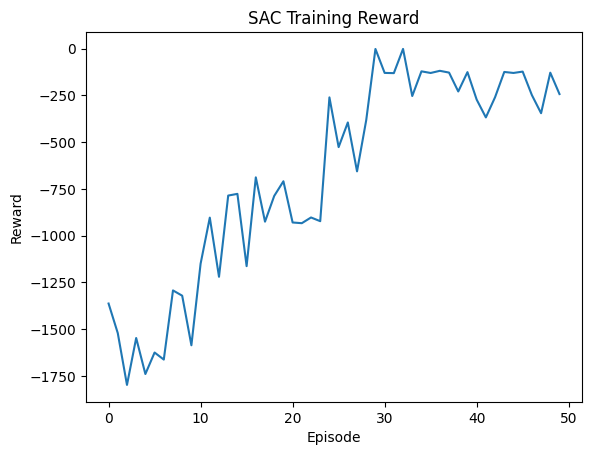

In [17]:
agent = SACAgent(state_dim=state_dim,action_dim=action_dim,min_action=min_action,max_action=max_action)

import matplotlib.pyplot as plt

episodes = 50
max_steps = 200
batch_size = 64

rewards_history = []

for ep in range(episodes):  
    state, _ = env.reset()
    episode_reward = 0

    for step in range(max_steps):
        # 1. Select action
        action = agent.select_action(state)  # state ต้องเป็น np.array, shape = [state_dim]

        # 2. Environment step
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # 3. Store transition
        agent.replay_buffer.push(state, action, reward, next_state, float(done))

        # 4. Update agent
        agent.update(batch_size)

        state = next_state
        episode_reward += reward

        if done:
            break
    
    rewards_history.append(episode_reward)
    print(f"Episode {ep+1}/{episodes} Reward: {episode_reward:.2f}")

# Plot reward
plt.plot(rewards_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("SAC Training Reward")
plt.show()
